<a href="https://colab.research.google.com/github/ReddySameer/tensorflow/blob/main/Copy_of_09_skimlit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project 2

* Build a NLP model to read medical abstracts
https://arxiv.org/abs/1710.0671

* fidn dataset
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Pre-Process data

* Read all the lines of the text file

In [ ]:
def get_lines(filename):
  """
  read the filename, and returns all the lines of text as a list

  Args:
    filename: filename target path

  Returns:
    A list of strings with one string per line read
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines  = get_lines(data_dir+"train.txt")
train_lines[:20], len(train_lines)

(['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
  'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) -

In [ ]:
 # create a function to read the lines into dictionary kind of structures
def preprocess_text_with_line_numbers(filename):
  """
  returns a list of dictionaries of abstract line data
  Takes in a filename, reads the contents and sorts eac line,
   extracts the specifics like target label,
    the text of the sentence,
   how many sentences in the abstract and what sentence the target line is
  """

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      anstract_id = line
      abstract_lines = "" # reset the abstract string if th eline isan ID line
    elif line.isspace(): # check to see if this a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # iterate each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary
        target_text_split = abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split) -1
        abstract_samples.append(line_data)

    else: # if the line contains a labelled sentece
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [ ]:
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df[:13]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

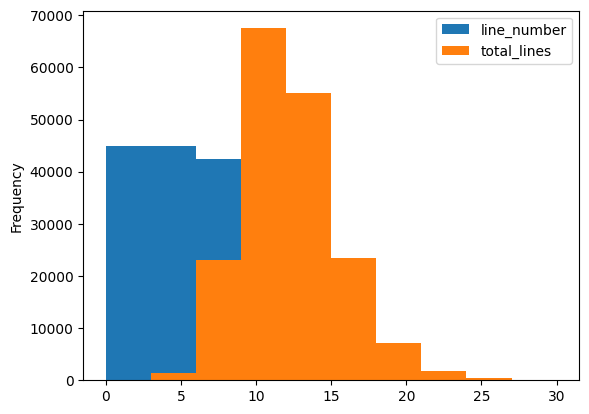

In [ ]:
train_df.plot.hist()

<Axes: ylabel='Frequency'>

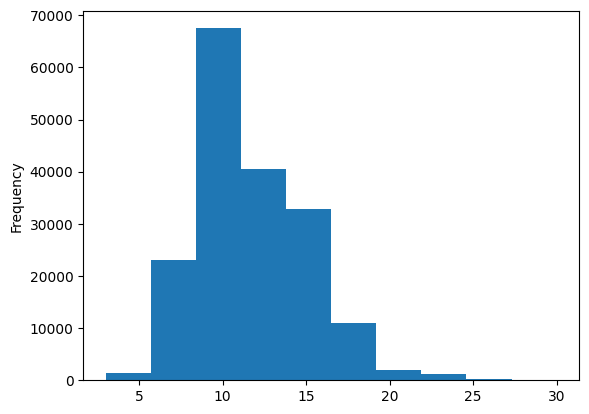

In [ ]:
train_df.total_lines.plot.hist()

# Get List of sentences

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#  make numeric labels ML models require numeric labels

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
import tensorflow as tf

# Matrices that contain mostly zero values, are called Sparse,

* Matrices that contain values that non-zero are called dense

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False) #for non Sparse
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
tf.constant(train_labels_one_hot)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

# to encode labels into numbers instead  of 0s or 1s

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder= LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())
train_labels_encoded[:120]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4, 4, 1,
       1, 0, 0, 2, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 1, 0, 3, 2, 2, 2, 2, 4,
       4, 4, 4, 4, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 2, 2, 2, 4, 4, 4, 1,
       1, 3, 3, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 1, 0, 0, 0, 2, 2, 2, 4, 4,
       4, 1, 3, 0, 2, 4, 4, 4, 4, 4, 4, 1, 1, 3, 2, 2, 2, 2, 2, 4, 4, 1,
       0, 0, 0, 2, 4, 4, 1, 1, 0, 0])

# Get class names and number of classes from LabelEncoder instances


In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Experimental models

0. Naive bayes with TF-IDF
1. Conv1D with token embeddings
2. Tensorflow Hub Pretrained Feature Extractor
3. Conv1D with character embeddings
4. PRetrained token embeddings(same as 2) + character embedding(same as 3)
5. Pretrained token embeddings + character embedding + positional Embeddings

# *model_0* Naive bayes with TF-IDF
* TF-IDF - Term frequency - Inverse Document Frequency

* tf-idf is a weighting system that assigns a weight to each word in a document based on its term frequency (tf) and the reciprocal document frequency (tf) (idf).
*  The words with higher scores of weight are deemed to be more significant

* TF -> Term Frequency - the number of instances of a given word in the doc

* DF -> Document Frequency -> the number of documents in which the word is present. This tests the meaning of the text

* IDF -> Inverse Document Frequency ->  it tests how relevant the word is.

# TfidfVectorizer

TF-IDF will transform the text into meaningful representation of integers or numbers which is used to fit machine learning algorithm for predictions. TF-IDF Vectorizer is a measure of originality of a word by comparing the number of times a word appears in document with the number of documents the word appears in

In [ ]:
# Create text Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
     ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-10 18:10:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-06-10 18:10:43 (15.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results


In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:2]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']

In [ ]:
# how long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

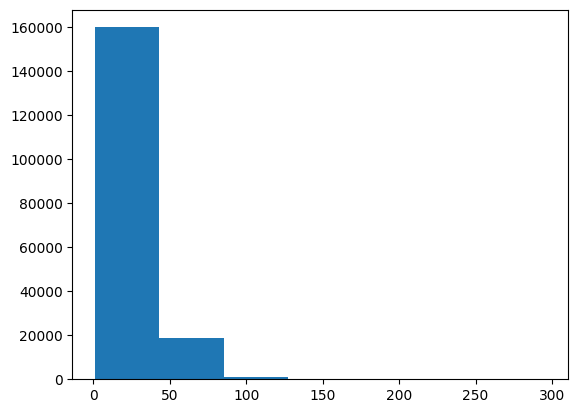

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7)

In [ ]:
# how long the sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

# create Text Vectorizer layer

* Convert words to numbers

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text=\n{target_sentence}")
print(f"\nLength of Text: {len(target_sentence)}")
print(f"\nVecotorized text:{text_vectorizer([target_sentence])}")

Text=
these factors accounted for most of the attribute effect on the dui decision , whereas delayed punishment due to judicial processing , fine penalty , and legal blood alcohol concentration ( bac ) limit had negligible effects .

Length of Text: 226


FailedPreconditionError: Exception encountered when calling layer 'string_lookup' (type StringLookup).

{{function_node __wrapped__LookupTableFindV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Table not initialized. [Op:LookupTableFindV2] name: 

Call arguments received by layer 'string_lookup' (type StringLookup):
  • inputs=<tf.RaggedTensor [[b'these', b'factors', b'accounted', b'for', b'most', b'of', b'the',
  b'attribute', b'effect', b'on', b'the', b'dui', b'decision', b'whereas',
  b'delayed', b'punishment', b'due', b'to', b'judicial', b'processing',
  b'fine', b'penalty', b'and', b'legal', b'blood', b'alcohol',
  b'concentration', b'bac', b'limit', b'had', b'negligible', b'effects']]>

In [ ]:
# how many words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f" Number of words in Vocabulary: {len(rct_20k_text_vocab)}")
print(f" Most common words in Vocabulary: {(rct_20k_text_vocab[:5])}")
print(f" least common words in Vocabulary: {(rct_20k_text_vocab[-5:])}")

 Number of words in Vocabulary: 64841
 Most common words in Vocabulary: ['', '[UNK]', 'the', 'and', 'of']
 least common words in Vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 2}

#### Create Custom Text Embedding

In [ ]:
# create token embedding layer

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, #
                               mask_zero=True, # to handle variable variable sequence lengths efficiently
                               name="token_embedding")  #

In [ ]:
print(f"Sentence before vecotorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vecotorization:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after Embedding:\n {embedded_sentence}\n")
print(f"Embedded SEntence shape: {embedded_sentence.shape}")


Sentence before vecotorization:
 a reduced sodium intake was associated with a significantly lower risk of headache , while dietary patterns had no effect on the risk of headaches in adults .

Sentence after vecotorization:
 [[   8  191  764  399   10   81    7    8   39  105   73    4 1309  258
   566 1429   55   33   70   18    2   73    4 5436    5  266    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after Embedding:
 [[[-0.03201276 -0.04430927  0.00861328 ... -0.00057783 -0.02797997
    0.02780397]
  [-0.03752538  0.00869171 -0.02557671 ...  0.04122866  0.03918007
    0.04861057]
  [ 0.03565706 -0.02678921  0.04324817 ... -0.02618047 -0.03165227
    0.02671552]
  ...
  [ 0.0039119   0.01495626 -0.03694657 ... -0.00045802 -0.02154553
    0.04152869]
  [ 0.0039119   0.01495626 -0.03694657 ... -0.00045802 -0.02154553
    0.04152869]
  [ 0.0039119   0.01495626 -0.03694657 ..

# Creating Datasets

* tensorflow.org/guide/data_performance
* tensorflow.org/guide/data

In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, val_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

# *model_1* Conv1D with Token Embedding


In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) #vectorize inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu") (token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1D")

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
model_3.summary()

Model: "model_1_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_8 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_7  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                    

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_model_1 = model_1.fit(train_dataset,
           steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=(val_dataset),
            validation_steps=int(0.1 * len(val_dataset))
            )

Epoch 1/3
562/562 [==============================] - 92s 160ms/step - loss: 0.3536 - accuracy: 0.5718 - val_loss: 0.2623 - val_accuracy: 0.7111
Epoch 2/3
562/562 [==============================] - 88s 157ms/step - loss: 0.2467 - accuracy: 0.7468 - val_loss: 0.2357 - val_accuracy: 0.7596
Epoch 3/3
562/562 [==============================] - 76s 136ms/step - loss: 0.2273 - accuracy: 0.7738 - val_loss: 0.2200 - val_accuracy: 0.7786


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.2188 - accuracy: 0.7866


[0.21884039044380188, 0.7865749001502991]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 8s 8ms/step


array([[5.3114212e-01, 1.5385187e-01, 6.6835590e-02, 2.1836995e-01,
        2.9800467e-02],
       [4.3961963e-01, 3.8731027e-01, 7.8055602e-03, 1.5802260e-01,
        7.2419317e-03],
       [8.7452590e-02, 3.0719687e-03, 4.1821902e-03, 9.0521246e-01,
        8.0823665e-05],
       ...,
       [3.1419623e-07, 1.9123727e-05, 1.0330596e-05, 1.3380103e-06,
        9.9996889e-01],
       [2.2155341e-02, 6.2749565e-01, 4.8281170e-02, 3.9684765e-02,
        2.6238307e-01],
       [2.0908545e-01, 6.6957366e-01, 6.7689724e-02, 2.8138801e-02,
        2.5512243e-02]], dtype=float32)

In [ ]:
model_1_pred_probs.shape

(30212, 5)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.65748709122204,
 'precision': 0.7808760323116372,
 'recall': 0.7865748709122203,
 'f1': 0.7817474063317437}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model_2 Pretrained Word Embeddings

* Glove Embedding - global vectors for Word Representation
* USE - Universal Sentence Encoder

In [ ]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                   trainable=False,
                                   name="universal_sentence_encoder")

In [ ]:
import random
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding:\n{use_embedded_sentence[0][:30]}")
print(f"length of sentence after embedding:\n{len(use_embedded_sentence[0])}")

Random sentence:
 the primary outcome was visual symptoms evaluated with the quality of vision ( qov ) questionnaire .


NameError: name 'tf_hub_embedding_layer' is not defined

# Build and Fit , an NLP feature extracion model using pretrained embeddings using Tensorflow


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x=layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))


Epoch 1/3
562/562 [==============================] - 14s 19ms/step - loss: 0.9164 - accuracy: 0.6491 - val_loss: 0.7978 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7703 - accuracy: 0.6996 - val_loss: 0.7581 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7552 - accuracy: 0.7104 - val_loss: 0.7428 - val_accuracy: 0.7138


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7434 - accuracy: 0.7131


[0.7434161305427551, 0.7130610346794128]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 15s 14ms/step


array([[4.3968317e-01, 3.6055845e-01, 2.9873827e-03, 1.8841515e-01,
        8.3557842e-03],
       [3.3326459e-01, 5.0334340e-01, 5.1976815e-03, 1.5488175e-01,
        3.3127081e-03],
       [2.3553984e-01, 1.3540317e-01, 2.1283833e-02, 5.6521654e-01,
        4.2556588e-02],
       ...,
       [1.8600302e-03, 5.4768007e-03, 5.7931427e-02, 9.3148992e-04,
        9.3380028e-01],
       [3.7659011e-03, 4.2719234e-02, 1.9305342e-01, 1.3734908e-03,
        7.5908792e-01],
       [1.4605045e-01, 2.4075331e-01, 5.3303915e-01, 6.6802027e-03,
        7.3476844e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

In [ ]:
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.30610353501919,
 'precision': 0.7135382671691459,
 'recall': 0.7130610353501919,
 'f1': 0.7100793403807393}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
inputs.shape

NameError: name 'inputs' is not defined

# Model_3 Conv1D with Character level embeddings

* character level embedding instead of word level embedding
* Character level Tokenizer

In [ ]:
# Make function to split sentences to characters
def split_chars(test):
  return " ".join(list(test))

In [ ]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
split_chars(random_train_sentence)

't h e   p r i m a r y   o u t c o m e   w a s   v i s u a l   s y m p t o m s   e v a l u a t e d   w i t h   t h e   q u a l i t y   o f   v i s i o n   (   q o v   )   q u e s t i o n n a i r e   .'

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# split sequence-level data splits into character-level data split

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]


['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# what's the average char length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

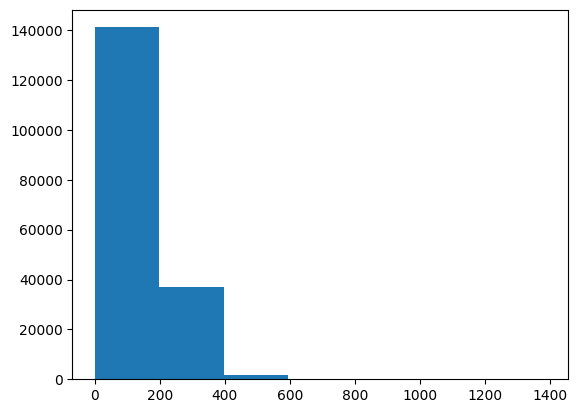

In [ ]:
# check the distribution of sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

most sentences seems to be at charlenght of around 200 from the above plot

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

this shows that the 95% of the sentences have about 290

# get all the chars on the keyboard

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)
#every char on the keyboard would be covered in the list

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

# Create char-level token vectorizer instance

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    #standardize=None,#"lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
# Adapt the char_vectorizer to trainig character
char_vectorizer.adapt(train_chars)

In [ ]:
#check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f" Number of diff. charcacter in character vocab:{len(char_vocab)}")
print(f" 5 most common characters in character vocab:{char_vocab[:5]}")
print(f" 5 least common characters in character vocab:{char_vocab[-5:]}")


 Number of diff. charcacter in character vocab:28
 5 most common characters in character vocab:['', '[UNK]', 'e', 't', 'i']
 5 least common characters in character vocab:['k', 'x', 'z', 'q', 'j']


#with standardization is null
* this will keep the punctuation

In [ ]:
#check character vocab stats **DONT RUN AGAIN**
char_vocab = char_vectorizer.get_vocabulary()
print(f" Number of diff. charcacter in character vocab:{len(char_vocab)}")
print(f" 5 most common characters in character vocab:{char_vocab[:5]}")
print(f" 5 least common characters in character vocab:{char_vocab[-5:]}")

 Number of diff. charcacter in character vocab:28
 5 most common characters in character vocab:['', '[UNK]', 'e', 't', 'i']
 5 least common characters in character vocab:['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"character text:\n {random_train_chars.split()}")
print(f"lenthg of random_train_chars:\n {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nlength of Vectorized_chars :\n {len(vectorized_chars[0])}")

character text:
 ['t', 'h', 'e', 'm', 'e', 'a', 'n', 's', 'e', 'r', 'u', 'm', 'c', 'r', 'e', 'a', 't', 'i', 'n', 'i', 'n', 'e', 'a', 'n', 'd', 'm', 'e', 'a', 'n', 'c', 'r', 'e', 'a', 't', 'i', 'n', 'i', 'n', 'e', 'c', 'l', 'e', 'a', 'r', 'a', 'n', 'c', 'e', 'w', 'e', 'r', 'e', '@', '(', '@', ')', '?']
lenthg of random_train_chars:
 139

Vectorized chars:
 [[ 3 13  2 15  2  5  6  9  2  8 16 15 11  8  2  5  3  4  6  4  6  2  5  6
  10 15  2  5  6 11  8  2  5  3  4  6  4  6  2 11 12  2  5  8  5  6 11  2
  20  2  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

# Character level embedding

* character vectorization has changed the words to characters to numbers to vectors
* turn the character vectorization to character embeddings


In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, #this is the size for char embedding from: https://arxiv.org/abs/1612.05251
                              mask_zero=False,
                              name="char_embed")

In [ ]:
print(f"charified text: \n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embeded chars. (after vectorization and embedding):\n {char_embed_example}")
char_embed_example.shape

charified text: 
 t h e   m e a n   s e r u m   c r e a t i n i n e   a n d   m e a n   c r e a t i n i n e   c l e a r a n c e   w e r e   @   (   @   )   ?
Embeded chars. (after vectorization and embedding):
 [[[-3.8375482e-03 -3.5406958e-02  2.4964165e-02 ...  3.8611803e-02
   -2.3365928e-02  3.2820825e-02]
  [-2.1908844e-02  4.4860724e-02 -5.8418512e-04 ...  2.0265426e-02
    3.4315955e-02 -3.2579206e-02]
  [-1.8718384e-02  4.7254059e-02  4.2252038e-02 ... -3.8910657e-05
   -8.6338408e-03 -3.2608055e-02]
  ...
  [-1.0693453e-02 -4.1054487e-02 -2.4022615e-02 ...  8.1129074e-03
   -3.2234825e-02  4.1139532e-02]
  [-1.0693453e-02 -4.1054487e-02 -2.4022615e-02 ...  8.1129074e-03
   -3.2234825e-02  4.1139532e-02]
  [-1.0693453e-02 -4.1054487e-02 -2.4022615e-02 ...  8.1129074e-03
   -3.2234825e-02  4.1139532e-02]]]


TensorShape([1, 290, 25])

### build Conv1D model to fit character level embedding

In [ ]:
inputs = layers.Input(shape=(1,1), dtype="string")
inputs.shape

TensorShape([None, 1, 1])

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
print(char_vectors.shape)
x = layers.Conv1D(filters=64,
                  kernel_size=5, # kernal_size to look at 5 words at a time
                  strides=1,
                  activation="relu",
                  padding="same")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu") (x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embedding")


(None, 290)


In [ ]:
inputs = layers.Input(shape=[], dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
print(char_embeddings.shape)
char_embeddings = tf.expand_dims(char_embeddings, axis=-1)
x = layers.Conv1D(64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(char_embeddings)
x = tf.squeeze(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embedding")


(None, 290, 25)


ValueError: as_list() is not defined on an unknown TensorShape.

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5

# optimize the data so that the performance is good - create Dataset

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

In [ ]:
train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")
model_3.compile(loss="categorical_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

model_3.summary()


Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 22s 36ms/step - loss: 1.4597 - accuracy: 0.3422 - val_loss: 1.4085 - val_accuracy: 0.3976
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 1.3632 - accuracy: 0.4236 - val_loss: 1.3284 - val_accuracy: 0.4435
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 1.3211 - accuracy: 0.4511 - val_loss: 1.3103 - val_accuracy: 0.4422


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[0.18625689, 0.2535425 , 0.23927698, 0.17637601, 0.1445476 ],
       [0.10709183, 0.16668868, 0.1749029 , 0.05946353, 0.49185306],
       [0.10485925, 0.1648769 , 0.40992162, 0.10788114, 0.21246113],
       ...,
       [0.05743968, 0.11036793, 0.20960255, 0.04050549, 0.5820843 ],
       [0.03821251, 0.09774171, 0.16168804, 0.04039475, 0.661963  ],
       [0.13921241, 0.1850234 , 0.18834898, 0.06621999, 0.4211953 ]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 4, 4])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 45.137693631669535,
 'precision': 0.3796210702893674,
 'recall': 0.45137693631669534,
 'f1': 0.398116948038843}

# Multi inputs: Combining token embeddings with char embeddings

1. Create a token level embedding model
2. Create a char level embedding model
3. Combine 1. & 2. with a concatenate (`layers.Concatenate`)
4. Build a series of output layers (section 3.2 in https://arxiv.org/abs/1612.05251)
5. Construct the model that receives the token level embedding with the char level embedding sequences as input and produces the sequence level probabilities as output

